# Pipeline

#### Pipeline
- streamline the workflow
- also help to ensure the training and testing data are treated consistently without leakage of information
#### Leakage
- mostly we use fit() and transform() method
- how to use .fit() and training data?
    - why only on training, this because, the while testing the objective of performance is already observed.
    - if so, if we see to set the data for test, this is will be no use.
- how to use .transform method.
    - this can be used on both training as well as testing.
- leakage occurs when a fit method is applied to the data.
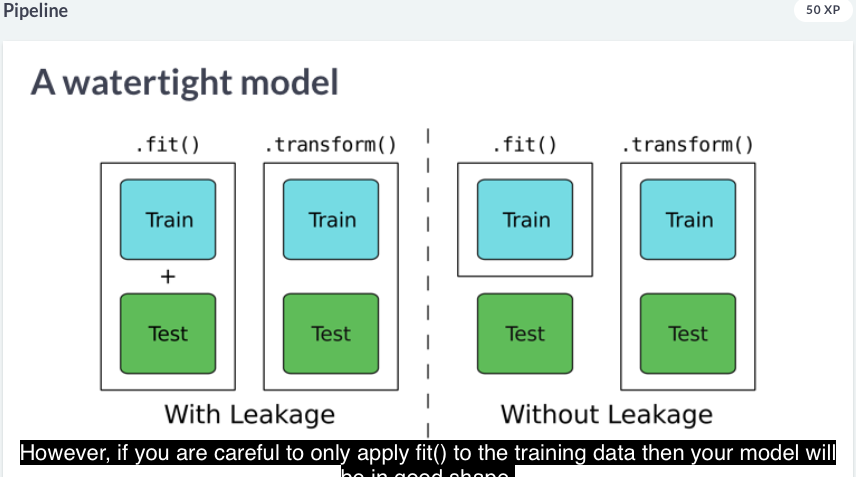

#### Pipeline is a mechnanism that combines series of steps 
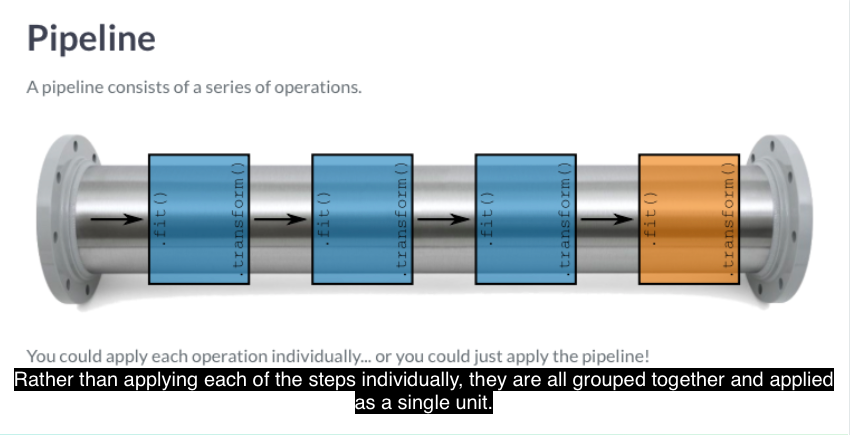

In [ ]:


# String Indexer
indexer  = StringIndexer(inputCol='type', outputCol='type_idx')

# to encode indexed values to dummy variables
onehot = OneHotEncoderEstimator(inputCols = ['type_idx'], outputlCols=['type_dummy'])

# assembling a set of predictors into a single feature columns
assemble  = VectorAssembler(inputCols =['mass', 'cyl', 'type_dummy'], outputCols='features')

# finnally a regression
regression  = LinearRegression(labelCol='consumption')

# Training data - indexer
indexer = indexer.fit(cars_train)
cars_train = indexer.transform(cars_train)

# Testing Data - indexer
cars_test = indexer.transform(cars_test)

# Training data - onehotencoder
onehot = onehot.fit(cars_train)
cars_train = onehot.transform(cars_train)

# Testing data - onehotencooder
cars_test = onehot.transform(cars_test)

# Training data - assembler, there is no fit method
cars_train = assemble.transform(cars_train)

# Testing data - assembler 
cars_train = assemble.transform(cars_test)

# training - regression 
regression = regression.fit(cars_train)

# Make predictions on testing data
predictions = regression.transform(cars_test)



In [ ]:
# A pipeline makes training and testing a complicated model much easier
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [indexer, onehot, assemble, regression])


# can call fit method on pipeline straight away - training
pipeline = pipeline.fit(cars_train)

# predicitions - testing 
predictions = pipeline.transform(cars_test)

# stages can be assessible using .stages
pipeline.stages[3]

print(pipeline.stage[3].intercept)
print(pipeline.stage[3].coefficients)




#### Flight duration model: Pipeline stages

You're going to create the stages for the flights duration model pipeline. You will use these in the next exercise to build a pipeline and to create a regression model.

In [ ]:
# Convert categorical strings to index values
indexer = StringIndexer(inputCol='org', outputCol='org_idx')

# One-hot encode index values
onehot = OneHotEncoderEstimator(
    inputCols=['org_idx','dow'],
    outputCols=['org_dummy','dow_dummy']
)

# Assemble predictors into a single column
assembler = VectorAssembler(inputCols=['km','org_dummy','dow_dummy'], outputCol='features')

# A linear regression object
regression = LinearRegression(labelCol='duration')

#### Flight duration model: Pipeline model

You're now ready to put those stages together in a pipeline.

You'll construct the pipeline and then train the pipeline on the training data. This will apply each of the individual stages in the pipeline to the training data in turn. None of the stages will be exposed to the testing data at all: there will be no leakage!

Once the entire pipeline has been trained it will then be used to make predictions on the testing data.

The data are available as flights, which has been randomly split into flights_train and flights_test.

In [ ]:
# Import class for creating a pipeline
from pyspark.ml import Pipeline

# Construct a pipeline
pipeline = Pipeline(stages=[indexer, onehot, assembler, regression])

# Train the pipeline on the training data
pipeline = pipeline.fit(flights_train)

# Make predictions on the testing data
predictions = pipeline.transform(flights_test)

#### SMS spam pipeline

You haven't looked at the SMS data for quite a while. Last time we did the following:

split the text into tokens
removed stop words
applied the hashing trick
converted the data from counts to IDF and
trained a linear regression model.
Each of these steps was done independently. This seems like a great application for a pipeline!

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

# Break text into tokens at non-word characters
tokenizer = Tokenizer(inputCol='text', outputCol='words')

# Remove stop words
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol='terms')

# Apply the hashing trick and transform to TF-IDF
hasher = HashingTF(inputCol=remover.getOutputCol(), outputCol="hash")
idf = IDF(inputCol=hasher.getOutputCol(), outputCol="features")

# Create a logistic regression object and add everything to a pipeline
logistic = LogisticRegression()
pipeline = Pipeline(stages=[tokenizer, remover, hasher, idf, logistic])

#### Cross-Validation
                                   -------------Data----------------
                                   ---Test---*****Train*************
- SPlit the data into Test and Training sets

- Before doing, randomize the data
- splitting the data into folds
    - if 5 folds, then it is five-fold cross-validation
    - keep the first fold, then evaluate on the four-folds
    - 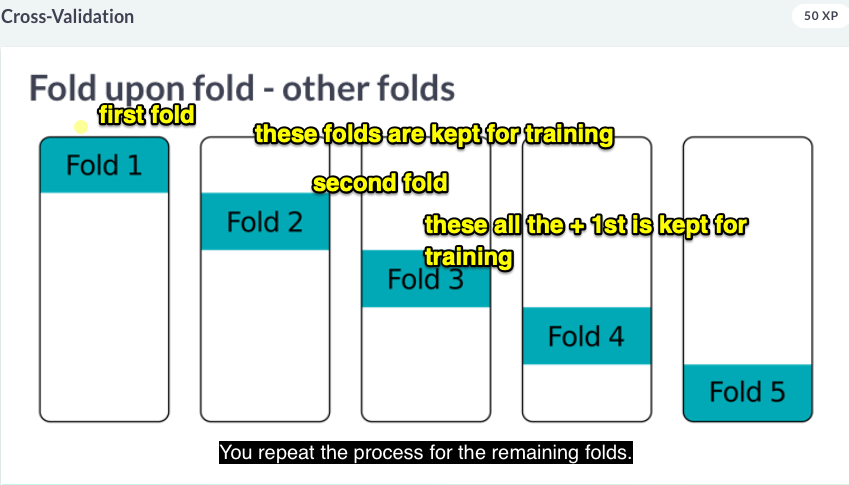
    - one point, u can calculate the average of all folds of evaluation metric

In [ ]:
cars.select('mass','cyl','consumption').show(5)

# an object to build the model, this can be pipeline
regression = LinearRegression(labelCol='consumption')

# evaluator to evaluate model performance
evaluator  = RegressionEvaluator(labelCol='consumption')

# Grid and cross validator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# a grid for parameter 
params = ParamGridBuilder().build()

# cross validation
cv = CrossValidator(estimator = regression, 
                   estimatorParamMaps = params, 
                   evaluator = evaluator,
                   numFolds=0, seed=13)

# cross-validation with fit() method
cv = cv.fit(cars_train)

# Average RootMSE
cv.avgMetrics

# Cross validations acts like models
evaluator.evaluate(cv.transform(cars_test))

# Much smaller than cv.RMSE



#### Cross validating simple flight duration model

You've already built a few models for predicting flight duration and evaluated them with a simple train/test split. However, cross-validation provides a much better way to evaluate model performance.

In this exercise you're going to train a simple model for flight duration using cross-validation. Travel time is usually strongly correlated with distance, so using the km column alone should give a decent model.

The data have been randomly split into flights_train and flights_test.

The following classes have already been imported: LinearRegression, RegressionEvaluator, ParamGridBuilder and CrossValidator.

In [ ]:
# Create an empty parameter grid
params = ParamGridBuilder().build()

# Create objects for building and evaluating a regression model
regression = LinearRegression(labelCol='duration')
evaluator = RegressionEvaluator(labelCol='duration')

# Create a cross validator
cv = CrossValidator(estimator=regression, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=13)

# Train and test model on multiple folds of the training data
cv = cv.fit(flights_train)

# NOTE: Since cross-valdiation builds multiple models, the fit() method can take a little while to complete.

#### Cross validating flight duration model pipeline

The cross-validated model that you just built was simple, using km alone to predict duration.

Another important predictor of flight duration is the origin airport. Flights generally take longer to get into the air from busy airports. Let's see if adding this predictor improves the model!

In this exercise you'll add the org field to the model. However, since org is categorical, there's more work to be done before it can be included: it must first be transformed to an index and then one-hot encoded before being assembled with km and used to build the regression model. We'll wrap these operations up in a pipeline.

The following objects have already been created:

params — an empty parameter grid
evaluator — a regression evaluator
regression — a LinearRegression object with labelCol='duration'.
All of the required classes have already been imported.

In [ ]:
# Create an indexer for the org field
indexer = StringIndexer(inputCol='org', outputCol='org_idx')

# Create an one-hot encoder for the indexed org field
onehot = OneHotEncoderEstimator(inputCols=['org_idx'], outputCols=['org_dummy'])

# Assemble the km and one-hot encoded fields
assembler = VectorAssembler(inputCols=['km','org_dummy'], outputCol='features')

# Create a pipeline and cross-validator.
pipeline = Pipeline(stages=[indexer, onehot, assembler, regression])
cv = CrossValidator(estimator=pipeline,
          estimatorParamMaps=params,
          evaluator=evaluator)

#### Grid Search
    - Model Parameter : Choosing the better one!!
- Linear Regression model with a intercept
regression = LinearRegression(labelCol='consumption', fitIntercept=True)
regression = regression.fit(cars_train)

- RMSE
- evaluator.evaluate(regression.transform(cars_test))

- Linear Regression model with a intercept specify FALSE
- regression = LinearRegression(labelCol='consumption', fitIntercept=False)
- regression = regression.fit(cars_train

- RMSE is higher
- evaluator.evaluate(regression.transform(cars_test))

- Systematically automate choosing the fitIntercept with True or False which will help to yield accurate RMSE


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

# Create a parameter grid builder
params = ParamGridBuilder()

# Add Grids
params = params.addGrid(regression.fitIntercept, [True, False])

# Construct the grid
params = params.build()

# How many models?
print('Number of models to be tested:', len(params))

# Now create Crossvalidator
cv = CrossValidator(estimator=regression,
          estimatorParamMaps=params,
          evaluator=evaluator)
cv = cv.setNumFolds(10).setSeed(13).fit(cars_train)
cv.avgMetrics # gives two different values

# Access Best Model
cv.bestModel

# cross validator acts as the best model
predictions = cv.transform(cars_test)

# retreive the best parameter
cv.bestmodel.explainParam('fitIntercept')

# a more complicated grid
params = ParamGridBuilder() \ 
        .addGrid(regression.fitIntercept, [True, False]) \
        .addGrid(regression.regParam.[0.001, 0.01, 0.1, 1, 10]) \
        .addGrid(regression.elasticNetParam, [0, 0.25, 0.5, 0.75, 1]) \
        .build()

print("Number of the models tested:", len(params))

#### Optimizing flights linear regression

Up until now you've been using the default parameters when building your models. In this exercise you'll use cross validation to choose an optimal (or close to optimal) set of model parameters.

The following have already been created:

regression — a LinearRegression object
pipeline — a pipeline with string indexer, one-hot encoder, vector assembler and linear regression and
evaluator — a RegressionEvaluator object.

In [ ]:
# Create parameter grid
params = ParamGridBuilder()

# Add grids for two parameters
params = params.addGrid(regression.regParam, [0.01, 0.1, 1.0, 10.0]) \
               .addGrid(regression.elasticNetParam, [0.0, 0.5, 1.0])

# Build the parameter grid
params = params.build()
print('Number of models to be tested: ', len(params))

# Create cross-validator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)

#### Dissecting the best flight duration model

You just set up a CrossValidator to find good parameters for the linear regression model predicting flight duration.

Now you're going to take a closer look at the resulting model, split out the stages and use it to make predictions on the testing data.

The following have already been created:

cv — a trained CrossValidatorModel object and
evaluator — a RegressionEvaluator object.
The flights data have been randomly split into flights_train and flights_test.

In [ ]:
# Get the best model from cross validation
best_model = cv.bestModel

# Look at the stages in the best model
print(best_model.stages)

# Get the parameters for the LinearRegression object in the best model
best_model.stages[3].extractParamMap()

# Generate predictions on testing data using the best model then calculate RMSE
predictions = best_model.transform(flights_test)
evaluator.evaluate(predictions)

# SMS spam optimised

The pipeline you built earlier for the SMS spam model used the default parameters for all of the elements in the pipeline. It's very unlikely that these parameters will give a particularly good model though.

In this exercise you'll set up a parameter grid which can be used with cross validation to choose a good set of parameters for the SMS spam classifier.

The following are already defined:

hasher — a HashingTF object and
logistic — a LogisticRegression object.

In [ ]:
# Create parameter grid
params = ParamGridBuilder()

# Add grid for hashing trick parameters
params = params.addGrid(hasher.numFeatures, [1024, 4096,16384] ) \
               .addGrid(hasher.binary, [True, False])

# Add grid for logistic regression parameters
params = params.addGrid(logistic.regParam, [0.01, 0.1, 1.0, 10.0]) \
               .addGrid(logistic.elasticNetParam, [0.0, 0.5, 1.0])

# Build parameter grid
params = params.build()

#### Ensemble
    - How Models can be combined to form an ENSEMBLE?
    - Wisdom of crowds : giving a decision to crowd and chose the best opted by the crowd.
    - Random Forrest : an ensemble of decision trees
        - Creating a model diversity
            1. Each tree trained on a random-subset of the data
            2. random subset of features used for splitting at each node
                    - No two trees in the random forest should be same
                    - 

In [ ]:
# Create a Random forest 
from pyspark.ml.classification import RandomForestClassifier
forest = RandomForestClassifier(numTrees = 5)

# fit for training
forest = forest.fit(cars_train)

# access the individual trees
forest.trees

# predict
predict = forest.transform(cars_test)

# Consensus prediction columns is produced by transform() method

# which of these most important?
forest.forestImportances

# observe the columns of the dataframes with values of output produced by forestImportances.

#### Gradient Boosted Trees
    - Interactive boosting algorithm:
    - now the trees that work in series.
    
 - Iterative boosting algorithm
    1. Build a Decision Tree and add to ensemble
    2. Predict label for each training instance using ensemble
    3. Compare Predictions with known labels.
    4. Emphazise training instances with incorrect pipelines
    5. Return to 1
    
 - Model improves on iteration
 

In [ ]:
# Boosting Trees
from spark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)

# Fitting
gbt = gbt.fit(cars_train)

# comparing the three types of tree models on testing data
# AUC of the decision tree
# AUC of Random forest
# AUC of Gradient-Boosted Tree



Delayed flights with Gradient-Boosted Trees

You've previously built a classifier for flights likely to be delayed using a Decision Tree. In this exercise you'll compare a Decision Tree model to a Gradient-Boosted Trees model.

The flights data have been randomly split into flights_train and flights_test.

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create model objects and train on training data
tree = DecisionTreeClassifier().fit(flights_train)
gbt = GBTClassifier().fit(flights_train)

# Compare AUC on testing data
evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(tree.transform(flights_test))
evaluator.evaluate(gbt.transform(flights_test))

# Find the number of trees and the relative importance of features
print(gbt.getNumTrees)
print(gbt.featureImportances)

#### Delayed flights with a Random Forest

In this exercise you'll bring together cross validation and ensemble methods. You'll be training a Random Forest classifier to predict delayed flights, using cross validation to choose the best values for model parameters.

You'll find good values for the following parameters:

featureSubsetStrategy — the number of features to consider for splitting at each node and
maxDepth — the maximum number of splits along any branch.
Unfortunately building this model takes too long, so we won't be running the .fit() method on the pipeline.

In [ ]:
# Create a random forest classifier
forest = RandomForestClassifier()

# Create a parameter grid
params = ParamGridBuilder() \
            .addGrid(forest.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2']) \
            .addGrid(forest.maxDepth, [2, 5, 10]) \
            .build()

# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator()

# Create a cross-validator
cv = CrossValidator(estimator=forest, estimatorParamMaps=params, evaluator=evaluator, numFolds=5)

#### Evaluating Random Forest

In this final exercise you'll be evaluating the results of cross-validation on a Random Forest model.

The following have already been created:

cv - a cross-validator which has already been fit to the training data
evaluator — a BinaryClassificationEvaluator object and
flights_test — the testing data.

In [ ]:
# Average AUC for each parameter combination in grid
avg_auc = cv.avgMetrics

# Average AUC for the best model
best_model_auc = max(cv.avgMetrics)

# What's the optimal parameter value?
opt_max_depth = cv.bestModel.explainParam('maxDepth')
opt_feat_substrat = cv.bestModel.explainParam('featureSubsetStrategy')

# AUC for best model on testing data
best_auc = evaluator.evaluate(cv.transform(flights_test))